In [20]:
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Monthly Seasonality

[*********************100%%**********************]  1 of 1 completed

Processing data for BTC-USD...



C:\Users\Administrator\AppData\Local\Temp\ipykernel_33288\1616914173.py:327: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df['Return'] = df['Close'].resample(period).ffill().pct_change() * 100
C:\Users\Administrator\AppData\Local\Temp\ipykernel_33288\1616914173.py:328: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df['Volume'] = df['Volume'].resample(period).sum()  # Sum volume for each period
C:\Users\Administrator\AppData\Local\Temp\ipykernel_33288\1616914173.py:335: FutureWarning: The provided callable <function mean at 0x000001C7A096EE80> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  seasonality_table = df.pivot_table(values=column, index=df.index.year, columns=df.index.month, aggfunc=np.mean)
C:\Users\Administrator\AppData\Local\Temp\ipykerne

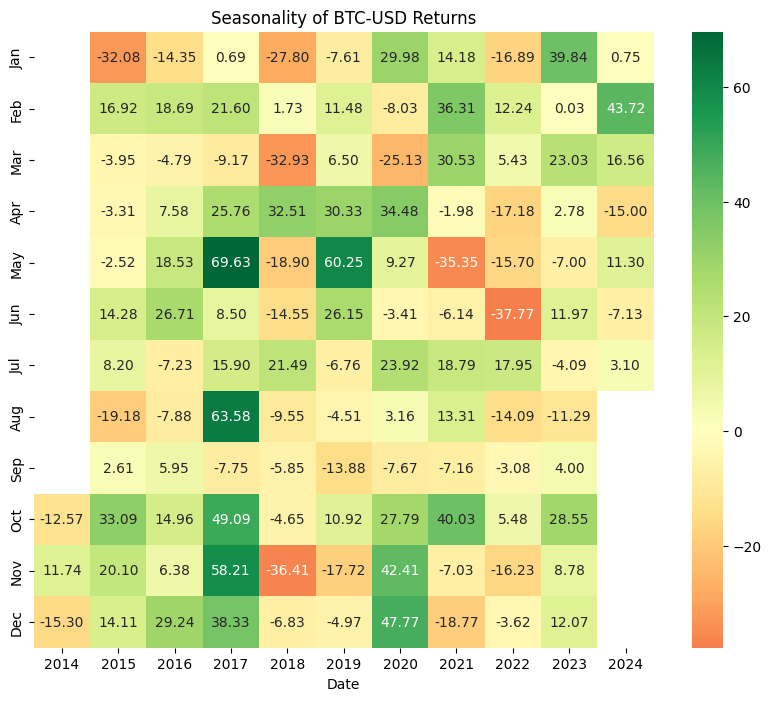

TypeError: display_all_monthly_statistics() takes 2 positional arguments but 3 were given

In [21]:
# List of tickers for assets
tickers = ['BTC-USD','ETH-USD']

for ticker in tickers:
    print(f"Processing data for {ticker}...")
    df = load_data(ticker)
    df = calculate_returns(df, period='M')
    seasonality_table = create_seasonality_table(df, column='Return')
    seasonality_volume_table = create_seasonality_table(df, column='Volume')
    visualize_seasonality_table(seasonality_table, ticker)
    display_all_monthly_statistics(seasonality_table, seasonality_volume_table, ticker)

# 52 Week Seasonality

[*********************100%%**********************]  2 of 2 completed



        Ticker: BTC-USD, Week: 1
        Volatility: 0.1029
        Positive Returns: 72.73%
        Kelly Ratio: 0.2273
        Mean Return: 1.25%
        Standard Deviation: 10.29%
        Highest Return: 16.67% in 2021
        Lowest Return: -18.39% in 2015
        Mean Volume: 18634040963.82
        Highest Volume: 76976400710.71 in 2021
        Lowest Volume: 12924566.67 in 2014
        Net Odds Received on the Wager: 2.67
        Probability of Winning (Positive Return): 72.73%
        Probability of Losing (Negative Return): 27.27%
        Kelly Fraction: 0.6250
        

        Ticker: BTC-USD, Week: 38
        Volatility: 0.0567
        Positive Returns: 40.00%
        Kelly Ratio: -0.1000
        Mean Return: -1.59%
        Standard Deviation: 5.67%
        Highest Return: 5.88% in 2020
        Lowest Return: -13.07% in 2014
        Mean Volume: 13796053879.11
        Highest Volume: 38585713490.43 in 2021
        Lowest Volume: 18093528.57 in 2015
        Net Odds Received

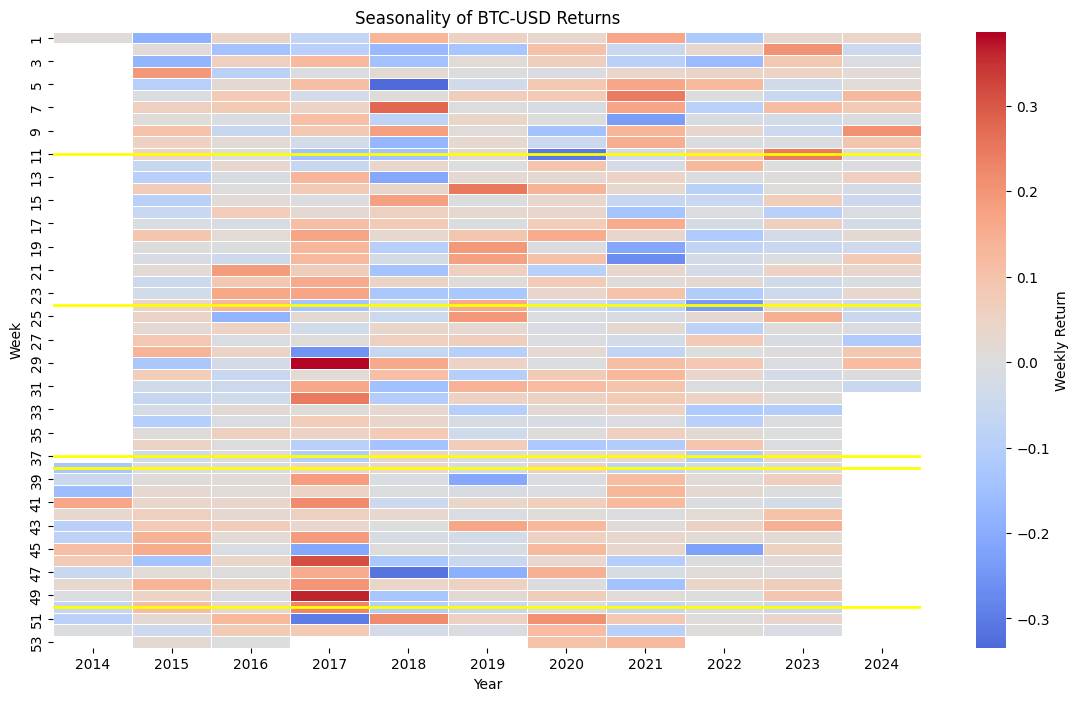


        Ticker: ETH-USD, Week: 1
        Volatility: 0.1559
        Positive Returns: 45.45%
        Kelly Ratio: -0.0455
        Mean Return: 6.47%
        Standard Deviation: 15.59%
        Highest Return: 39.49% in 2018
        Lowest Return: -18.68% in 2022
        Mean Volume: 13259167679.87
        Highest Volume: 43119247156.00 in 2021
        Lowest Volume: 4086069889.00 in 2023
        Net Odds Received on the Wager: 0.83
        Probability of Winning (Positive Return): 45.45%
        Probability of Losing (Negative Return): 54.55%
        Kelly Fraction: -0.2000
        

        Ticker: ETH-USD, Week: 38
        Volatility: 0.0582
        Positive Returns: 30.00%
        Kelly Ratio: 0.0000
        Mean Return: 1.31%
        Standard Deviation: 5.82%
        Highest Return: 11.70% in 2018
        Lowest Return: -6.47% in 2021
        Mean Volume: 11739593636.43
        Highest Volume: 23676588113.00 in 2021
        Lowest Volume: 1969634285.71 in 2018
        Net Odds Rece

C:\Users\Administrator\AppData\Local\Temp\ipykernel_33288\2150503825.py:62: RuntimeWarning: divide by zero encountered in scalar divide
  kelly_fraction = (probability_of_winning * net_odds - probability_of_losing) / net_odds


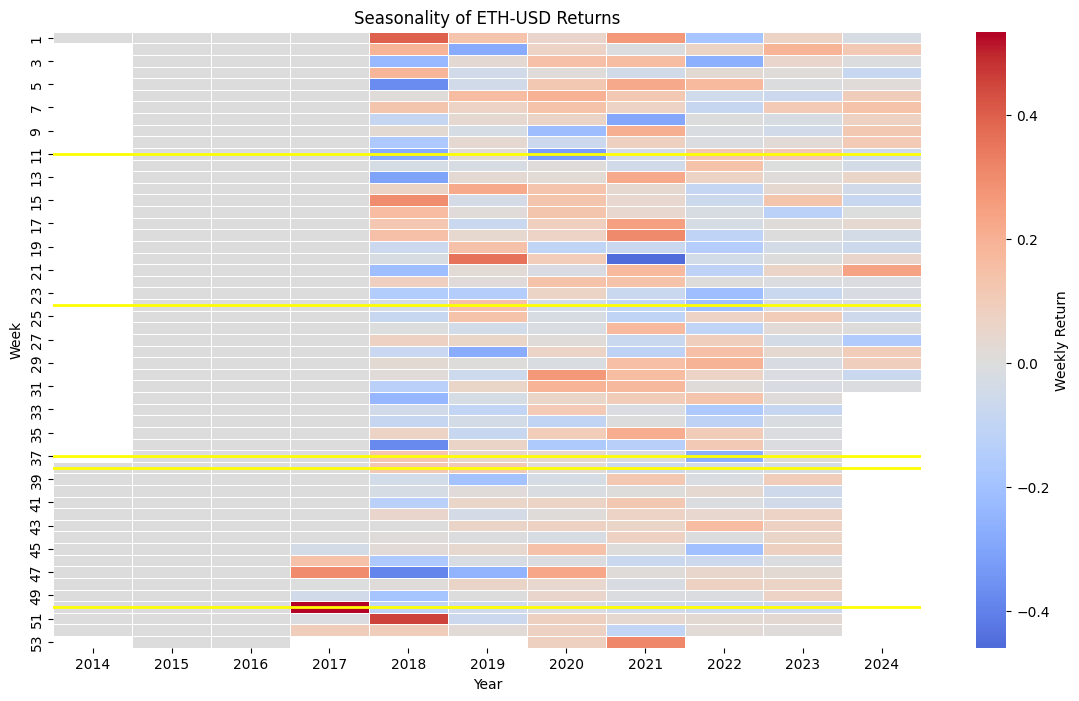

In [19]:
# List of tickers for assets
tickers = ['BTC-USD','ETH-USD']

# Download historical data for all tickers
data = yf.download(tickers, start="2010-01-01", end="2024-08-01", group_by='ticker')

# Define Triple Witching Weeks (approximate)
triple_witching_weeks = [11, 24, 37, 38, 50]

# Prepare a DataFrame to hold all the processed data
all_data = []

for ticker in tickers:
    # Calculate weekly returns and volume statistics
    df = data[ticker].copy()
    df['Return'] = df['Adj Close'].pct_change()
    df['Week_Number'] = df.index.isocalendar().week
    df['Year'] = df.index.year
    df['Ticker'] = ticker
    
    # Group data by year and week number
    weekly_data = df.groupby(['Year', 'Week_Number']).agg({
        'Return': 'sum',
        'Volume': 'mean'
    }).reset_index()
    weekly_data['Week'] = weekly_data['Week_Number'].astype(int)
    
    # Calculate additional metrics
    volatility = weekly_data.groupby('Week')['Return'].std().reset_index(name='Volatility')
    positive_returns = weekly_data.groupby('Week')['Return'].apply(lambda x: (x > 0).mean()).reset_index(name='Positive_Returns')
    
    # Calculate Kelly Ratio (assuming 2:1 odds for simplicity)
    kelly_ratio = (positive_returns['Positive_Returns'] * 2 - 1) / 2
    weekly_data = weekly_data.merge(volatility, on='Week')
    weekly_data = weekly_data.merge(positive_returns, on='Week')
    weekly_data['Kelly_Ratio'] = kelly_ratio
    
    for week in weekly_data['Week'].unique():
        weekly_subset = weekly_data[weekly_data['Week'] == week]
        mean_return = weekly_subset['Return'].mean()
        std_dev = weekly_subset['Return'].std()
        highest_return = weekly_subset['Return'].max()
        highest_return_year = weekly_subset.loc[weekly_subset['Return'].idxmax(), 'Year']
        lowest_return = weekly_subset['Return'].min()
        lowest_return_year = weekly_subset.loc[weekly_subset['Return'].idxmin(), 'Year']
        mean_volume = weekly_subset['Volume'].mean()
        highest_volume = weekly_subset['Volume'].max()
        highest_volume_year = weekly_subset.loc[weekly_subset['Volume'].idxmax(), 'Year']
        lowest_volume = weekly_subset['Volume'].min()
        lowest_volume_year = weekly_subset.loc[weekly_subset['Volume'].idxmin(), 'Year']
        
        probability_of_winning = weekly_subset['Positive_Returns'].mean()
        probability_of_losing = 1 - probability_of_winning
        net_odds = probability_of_winning / probability_of_losing
        kelly_fraction = (probability_of_winning * net_odds - probability_of_losing) / net_odds

        log = f"""
        Ticker: {ticker}, Week: {week}
        Volatility: {weekly_data.loc[weekly_data['Week'] == week, 'Volatility'].values[0]:.4f}
        Positive Returns: {weekly_data.loc[weekly_data['Week'] == week, 'Positive_Returns'].values[0]*100:.2f}%
        Kelly Ratio: {weekly_data.loc[weekly_data['Week'] == week, 'Kelly_Ratio'].values[0]:.4f}
        Mean Return: {mean_return*100:.2f}%
        Standard Deviation: {std_dev*100:.2f}%
        Highest Return: {highest_return*100:.2f}% in {int(highest_return_year)}
        Lowest Return: {lowest_return*100:.2f}% in {int(lowest_return_year)}
        Mean Volume: {mean_volume:.2f}
        Highest Volume: {highest_volume:.2f} in {int(highest_volume_year)}
        Lowest Volume: {lowest_volume:.2f} in {int(lowest_volume_year)}
        Net Odds Received on the Wager: {net_odds:.2f}
        Probability of Winning (Positive Return): {probability_of_winning*100:.2f}%
        Probability of Losing (Negative Return): {probability_of_losing*100:.2f}%
        Kelly Fraction: {kelly_fraction:.4f}
        """
        print(log)

    # Pivot the data for heatmap creation
    pivot_data = weekly_data.pivot(index="Week", columns="Year", values="Return")
    
    # Plot the heatmap with enhanced contrast and triple witching weeks highlighted
    plt.figure(figsize=(14, 8))
    sns.heatmap(pivot_data, annot=False, fmt=".2f", cmap="coolwarm", center=0, linewidths=.5, 
                cbar_kws={'label': 'Weekly Return'})
    
    # Highlight Triple Witching Weeks
    for week in triple_witching_weeks:
        plt.axhline(y=week-0.5, color='yellow', linewidth=2)
    
    plt.title(f'Seasonality of {ticker} Returns')
    plt.show()
